[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91638\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\91638\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\91638\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Enter the text you want to search : indian_economy
Enter the Start_date :
Enter the End_date :
Enter the count :50


C:\Users\91638\AppData\Local\Temp\ipykernel_13496\1101741263.py:31: DeprecatedFeatureWarning: content is deprecated, use rawContent instead
  tweets_list1.append([tweet.date, tweet.id, tweet.content, tweet.user.username, tweet.url, tweet.replyCount,  tweet.retweetCount,tweet.lang, tweet.likeCount ])


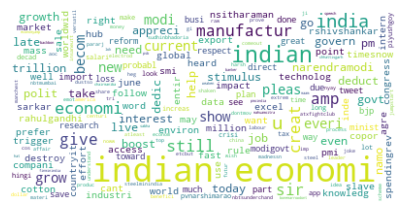

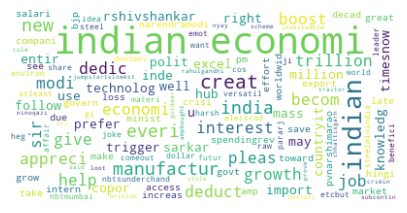

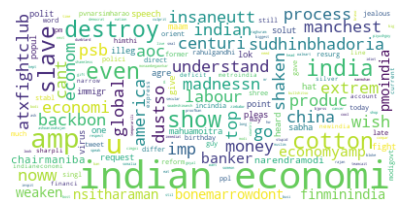

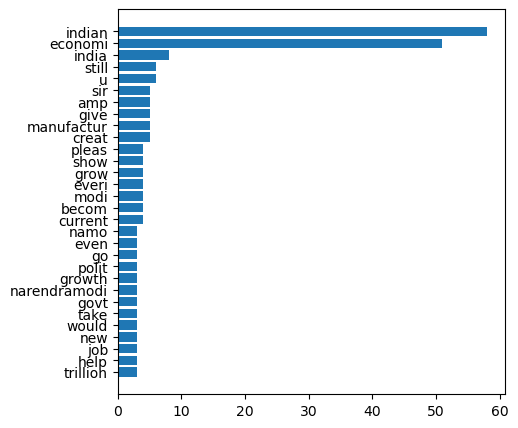

In [2]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import string 
import re
import docx
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')
stemmer=nltk.SnowballStemmer("english")
stopword=set(stopwords.words('english'))
nltk.download('vader_lexicon')
from nltk import FreqDist
nltk.download('vader_lexicon')
sentiments=SentimentIntensityAnalyzer()
doc = docx.Document()
tweets_list1 = []
default_since = '2019-01-01'
default_until = '2019-06-30'
search = input("Enter the text you want to search : ")
since = input('Enter the Start_date :') or default_since
until = input('Enter the End_date :') or default_until
maxTweets = int(input('Enter the count :'))
passing = (f'{search} since:{since} until:{until}')
for i,tweet in enumerate(sntwitter.TwitterSearchScraper(passing).get_items()):
    if i>maxTweets:
        break
    tweets_list1.append([tweet.date, tweet.id, tweet.content, tweet.user.username, tweet.url, tweet.replyCount,  tweet.retweetCount,tweet.lang, tweet.likeCount ])
df = pd.DataFrame(tweets_list1, columns=['DateTime', 'Tweet_ID', 'Content', 'User_Name', 'URL', 'Reply_count', 'Re_Tweet_Count','Language', 'Like_Count'])
doc.add_heading(f'{search}_tweets_Analysis')
doc.add_paragraph('\n')
doc.add_heading('Dataframe: ')
doc.add_paragraph('\n')
t = doc.add_table(df.shape[0]+1, df.shape[1])
for j in range(df.shape[-1]):
    t.cell(0,j).text = df.columns[j]
for i in range(df.shape[0]):
    for j in range(df.shape[-1]):
        t.cell(i+1,j).text = str(df.values[i,j])

def clean(text):
    text=str(text).lower()
    text=re.sub('\[.*?\]', '',text)
    text=re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
df['Content'] = df['Content'].apply(clean)
# Frequent words
text=" ".join(i for i in df.Content)
stopwords=set(STOPWORDS)
wordcloud=WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure(figsize=(5,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig(f'{search}.png')
doc.add_page_break()
doc.add_heading('Frequently used words')
doc.add_picture(f'{search}.png')
df['Positive']=[sentiments.polarity_scores(i)["pos"] for i in  df['Content']]
df['Negative']=[sentiments.polarity_scores(i)["neg"] for i in df['Content']]
df['Neutral']=[sentiments.polarity_scores(i)["neu"] for i in df['Content']]
df=df[['Content', 'Positive', 'Negative', 'Neutral']]
try:
    positive=' '.join([i for i in df['Content'][df['Positive'] > df['Negative']]])
    stopwords=set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(positive)
    plt.figure( figsize=(5,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig(f'{search}_positive.png')
    doc.add_page_break()
    doc.add_heading('Frequently used Positive words')
    doc.add_picture(f'{search}_positive.png')
    
except:
    doc.add_paragraph('There is no Positive words used')
try:
    negative=' '.join([i for i in df['Content'][df['Negative'] > df['Positive']]])
    stopwords=set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(negative)
    plt.figure( figsize=(5,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig(f'{search}_negative.png')
    doc.add_page_break()
    doc.add_heading('Frequently used Negative words used')
    doc.add_picture(f'{search}_negative.png')
except:
    doc.add_paragraph('There is no negative words')
try:
    all_words = ' '.join([text for text in df['Content']])
    all_words = all_words.split()
    words_df = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})
    words_df = words_df.nlargest(columns="count", n = 30) 
    words_df.sort_values('count', inplace = True)
    plt.figure(figsize=(5,5))
    ax = plt.barh(words_df['word'], width = words_df['count'])
    plt.savefig(f'{search}_frequent.png')
    doc.add_page_break()
    doc.add_heading('Top words that repeated in many tweets')
    doc.add_picture(f'{search}_frequent.png')
    doc.add_page_break()
except:
    doc.add_paragraph()
x = sum(df["Positive"])
y = sum(df["Negative"])
z = sum(df["Neutral"])

def sentiment_score(a, b, c):
    if (a>b) and (a>c):
        doc.add_paragraph("The tweets that frequently contain: Positive Words 😊 ")
    elif (b>a) and (b>c):
        doc.add_paragraph("The tweets that frequently contain: Negative Words 😠 ")
    else:
        doc.add_paragraph("The tweets that frequently contain: Neutral Words🙂 ")
sentiment_score(x, y, z)
doc.add_heading('Overall Scores:')
doc.add_paragraph(f"Positive: {x}")
doc.add_paragraph(f"Negative: {y}")
doc.add_paragraph(f"Neutral: {z}")
doc.save(f'{search}.docx')